# Computing continuous indices from Banff scores

Author: Thibaut Vaulet

Date: May 2025

This notebook provides a minimal working example to reproduce the modeling of continuous indices, as described in the paper: _Continuous indices to assess the phenotypic spectrum of kidney transplant rejection_ by Vaulet et al.

In [1]:
import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel

## 1. Data loading
Load a minimal working example dataset of 300 biopsies that captures the key structure needed to run the model.


In [2]:
df=pd.read_excel('minimalDF.xlsx',index_col=0)

## 2. Compute indices

### AMR/MVI index
In this example, we compute the optimal AMR/MVI index based on 4 lesion scores: g, ptc, cg and C4d.
We use the `OrderedModel` class to estimate a continuous latent variable representing the AMR continuum underlying the observed binary outcome (AMR vs. no AMR). Note that `OrderedModel` naturally extends beyond binary classification to handle ordinal outcomes.

In [3]:
outcome='AMR'  #binary indicator AMR vs no AMR
lesions= ['g', 'ptc', 'cg','C4d']

mod_prob = OrderedModel(df[outcome],df[lesions],distr='probit')

res_prob = mod_prob.fit(method='bfgs')
predicted = res_prob.model.predict(res_prob.params, exog=df[lesions].values,which='linpred') #exctract predictions
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.069911
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                    AMR   Log-Likelihood:                -20.973
Model:                   OrderedModel   AIC:                             51.95
Method:            Maximum Likelihood   BIC:                             70.47
Date:                Thu, 22 May 2025                                         
Time:                        11:14:54                                         
No. Observations:                 300                                         
Df Residuals:                     295                                         
Df Model:                           5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
g              0.8634      0.210      4.104      0.000       0.451       1.276
ptc            0.5527      0.242      2.288      0.022       0.079       1.026
cg             0.6165      0.252      2.443      0.015       0.122       1.111
C4d            2.3535      0.529      4.453      0.000       1.318       3.389
0/1            3.0429      0.430      7.082      0.000       2.201       3.885
==============================================================================
"""

0/1 correspsonds to the optimized discretization cut-off value 

Note that similar results can be obtained in R using the following code (binary outcome only):

`%R modelAMR <- glm(AMR ~ g+cg+ptc+C4d , family = binomial(link = "probit"), data = df)`

#### Re-scale index to the [0-10] interval 

In [4]:
#compute theoretical maximal value, if all lesions are at maximum values:
maxV=3*0.863372+3* 0.552672+3*0.616468+1*2.353500

In [5]:
#rescale coefficients
scaledCoef=res_prob.params[:-1]*10/maxV
scaledCoef

g      1.021616
ptc    0.653969
cg     0.729459
C4d    2.784865
dtype: float64

--> formula for AMR/MVI index (on this toy dataset): 1.022 x g +0.654 x ptc +0.729 x cg +2.785 x C4d

### TCMR/TI index

In [6]:
#example with TCMR
outcome='TCMR'  #binary indicator TCMR vs no TCMR
lesions= ['t', 'i', 'v','ct']

mod_probTCMR = OrderedModel(df[outcome],df[lesions],distr='probit')

res_probTCMR = mod_probTCMR.fit(method='bfgs')
res_probTCMR.summary()

Optimization terminated successfully.
         Current function value: 0.090804
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   TCMR   Log-Likelihood:                -27.241
Model:                   OrderedModel   AIC:                             64.48
Method:            Maximum Likelihood   BIC:                             83.00
Date:                Thu, 22 May 2025                                         
Time:                        11:15:01                                         
No. Observations:                 300                                         
Df Residuals:                     295                                         
Df Model:                           5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
t              0.6865      0.299      2.296      0.022       0.100       1.273
i              0.8022      0.226      3.549      0.000       0.359       1.245
v              2.8842      0.573      5.037      0.000       1.762       4.007
ct             0.6252      0.275      2.276      0.023       0.087       1.164
0/1            4.0652      0.692      5.879      0.000       2.710       5.421
==============================================================================
"""

In [7]:
#compute theoretical maximal value, if all lesions are at maximum values:
maxV_TCMR=3*0.6865+3*0.8022+3*2.8842+3*0.6252

In [8]:
#rescale coefficients
scaledCoefTCMR=res_probTCMR.params[:-1]*10/maxV_TCMR
scaledCoefTCMR

t     0.457818
i     0.535001
v     1.923549
ct    0.416941
dtype: float64


--> formula for TCMR/TI index (on this toy dataset): 0.458 x t + 0.535 x i + 1.924 x v + 0.417 x ct

## 3. Compute existing indices on a given dataset
Based on the formulas described in the paper. A quick way to compute the indices from a formula is to use the `eval()` function of pandas dataframe.

In [9]:
#formulas:
fAI='g+t+i+v+ptc+2*C4d'
fCI='2*cg+ci+ct+cv'
fAMRindex='g*0.938 +ptc*0.762 +cg*0.728 +C4d*2.716'
fTCMRindex='i*0.970+t*0.623+v*1.540+ct*0.195'

In [10]:
df['ActivityIndex']=df[['v','i','t','C4d','ptc','g']].eval(fAI)
df['ChronicityIndex']=df[['ci','ct','cg','cv']].eval(fCI)
df['TCMRindex']=df[['v','i','t','ct']].eval(fTCMRindex)
df['AMRindex']=df[['g','ptc','cg','C4d']].eval(fAMRindex)

<Axes: ylabel='Density'>

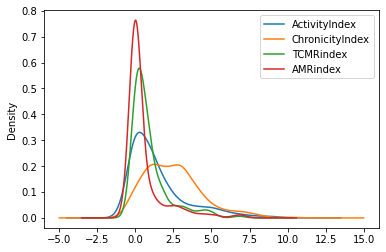

In [15]:
df[['ActivityIndex','ChronicityIndex','TCMRindex','AMRindex']].plot.kde()

In [17]:
df[['ActivityIndex','ChronicityIndex','TCMRindex','AMRindex']].describe().T

,count,mean,std,min,25%,50%,75%,max
ActivityIndex,300.0,1.443333,1.863248,0.0,0.000,1.000,2.000,9.000
ChronicityIndex,300.0,2.486667,1.853269,0.0,1.000,2.000,3.000,10.000
TCMRindex,300.0,0.898783,1.226452,0.0,0.195,0.585,1.013,6.904
AMRindex,300.0,0.540260,1.273484,0.0,0.000,0.000,0.000,7.054
